# Handwritten Digit Recognition
- Author = Amitrajit Bose
- Dataset = MNIST
- [Medium Article Link](https://medium.com/@amitrajit_bose/handwritten-digit-mnist-pytorch-977b5338e627)
- Frameworks = PyTorch


### Necessary Imports

In [1]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

In [2]:
import os

### Download The Dataset & Define The Transforms

In [3]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

### Exploring The Data

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.__next__()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


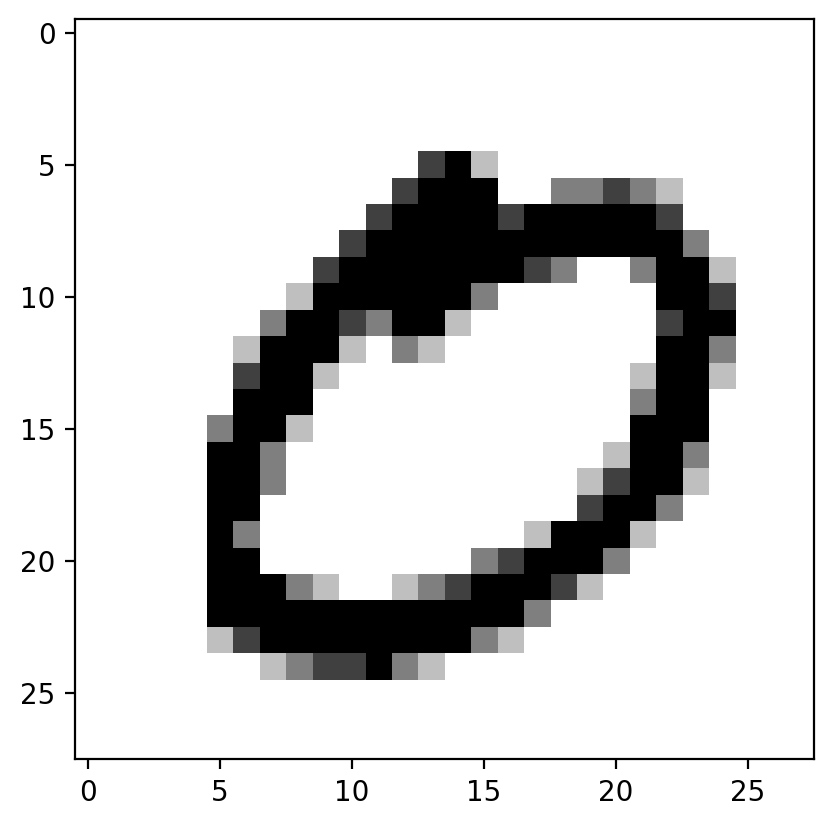

In [5]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

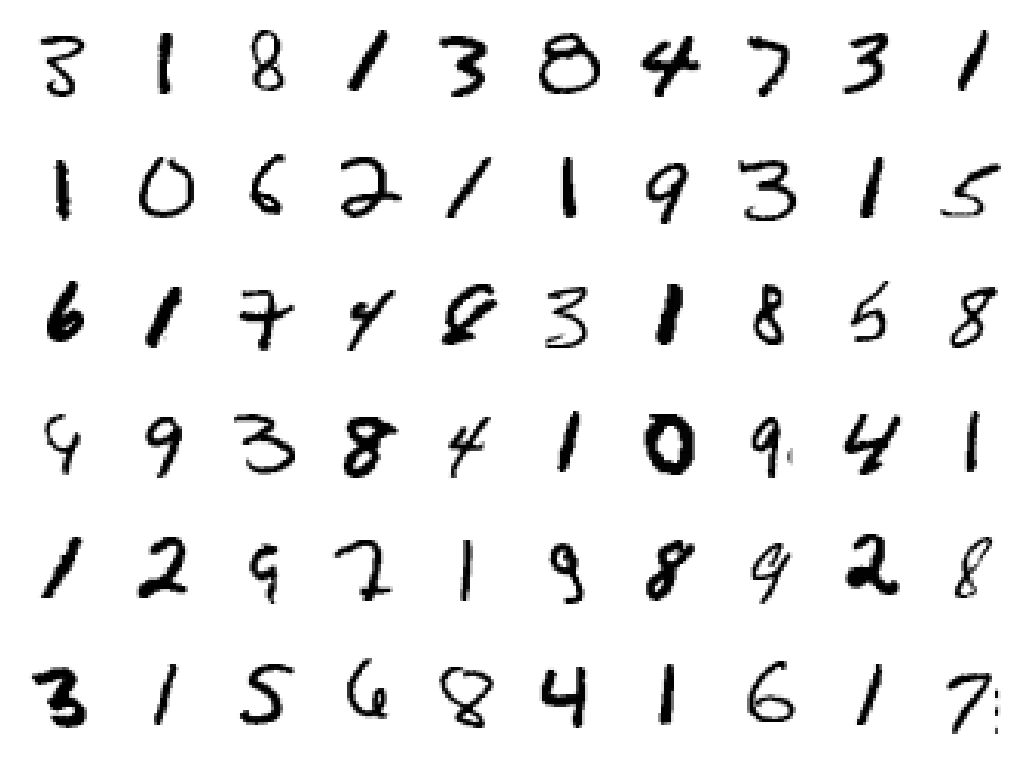

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Defining The Neural Network

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)

In [7]:
from torch import nn

# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
model.to(device)

mps


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

In [9]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

# Transfer tensors to MPS or fallback device
images, labels = images.to(device), labels.to(device)

logps = model(images)
loss = criterion(logps, labels)

In [10]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [-0.0042, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
        [-0.0015, -0.0015, -0.0015,  ..., -0.0015, -0.0015, -0.0015],
        ...,
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        [-0.0025, -0.0025, -0.0025,  ..., -0.0025, -0.0025, -0.0025],
        [ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009]],
       device='mps:0')


In [11]:
def custom_optimizer(model, learning_rate):
    with torch.no_grad():  # Ensure no gradient computation within this block
        for param in model.parameters():
            if param.grad is not None:
                #print(param.grad)
                # Update thse weights using simple gradient descent
                param -= learning_rate * param.grad

In [12]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
#optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images.to(device))
loss = criterion(output, labels.to(device))
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-0.0082, -0.0002, -0.0103,  ...,  0.0233, -0.0263,  0.0226],
        [ 0.0333, -0.0291,  0.0161,  ..., -0.0057,  0.0229,  0.0140],
        [ 0.0111, -0.0057,  0.0206,  ..., -0.0233, -0.0056,  0.0046],
        ...,
        [ 0.0131,  0.0198,  0.0190,  ..., -0.0251,  0.0158,  0.0133],
        [ 0.0283,  0.0210,  0.0241,  ..., -0.0069, -0.0202,  0.0256],
        [ 0.0292, -0.0328, -0.0113,  ..., -0.0217,  0.0118, -0.0012]],
       device='mps:0', requires_grad=True)


Gradient - tensor([[-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [-0.0051, -0.0051, -0.0051,  ..., -0.0051, -0.0051, -0.0051],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        ...,
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003],
        [-0.0032, -0.0032, -0.0032,  ..., -0.0032, -0.0032, -0.0032],
        [ 0.0014,  0.0014,  0.0014,  ...,  0.0014,  0.0014,  0.0014]],
       device='mps:0')


In [13]:
# Take an update step and few the new weights
custom_optimizer(model, learning_rate=0.01)
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-0.0082, -0.0002, -0.0103,  ...,  0.0233, -0.0263,  0.0226],
        [ 0.0334, -0.0291,  0.0161,  ..., -0.0057,  0.0229,  0.0140],
        [ 0.0111, -0.0057,  0.0206,  ..., -0.0233, -0.0056,  0.0046],
        ...,
        [ 0.0131,  0.0198,  0.0190,  ..., -0.0251,  0.0158,  0.0133],
        [ 0.0283,  0.0211,  0.0241,  ..., -0.0068, -0.0202,  0.0256],
        [ 0.0292, -0.0328, -0.0113,  ..., -0.0217,  0.0118, -0.0012]],
       device='mps:0', requires_grad=True)


### Core Training Of Neural Network

In [14]:

time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        output = model(images.to(device))
        loss = criterion(output, labels.to(device))

        #Manually clear out the gradients
        for param in model.parameters():
            param.grad = None

        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        custom_optimizer(model, learning_rate=0.03)
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


Epoch 0 - Training loss: 0.6310808519755345
Epoch 1 - Training loss: 0.2811456211546718
Epoch 2 - Training loss: 0.21613006674642884
Epoch 3 - Training loss: 0.17711720228798863
Epoch 4 - Training loss: 0.14923345698103277
Epoch 5 - Training loss: 0.1293820760953528
Epoch 6 - Training loss: 0.11487176343560346
Epoch 7 - Training loss: 0.10217587765095744
Epoch 8 - Training loss: 0.09189346218223511
Epoch 9 - Training loss: 0.08407840603537588
Epoch 10 - Training loss: 0.07668012626139499
Epoch 11 - Training loss: 0.07039634959905275
Epoch 12 - Training loss: 0.06508386189213344
Epoch 13 - Training loss: 0.05999111224324313
Epoch 14 - Training loss: 0.05509796167568945

Training Time (in minutes) = 0.9939694166183471


In [15]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 8


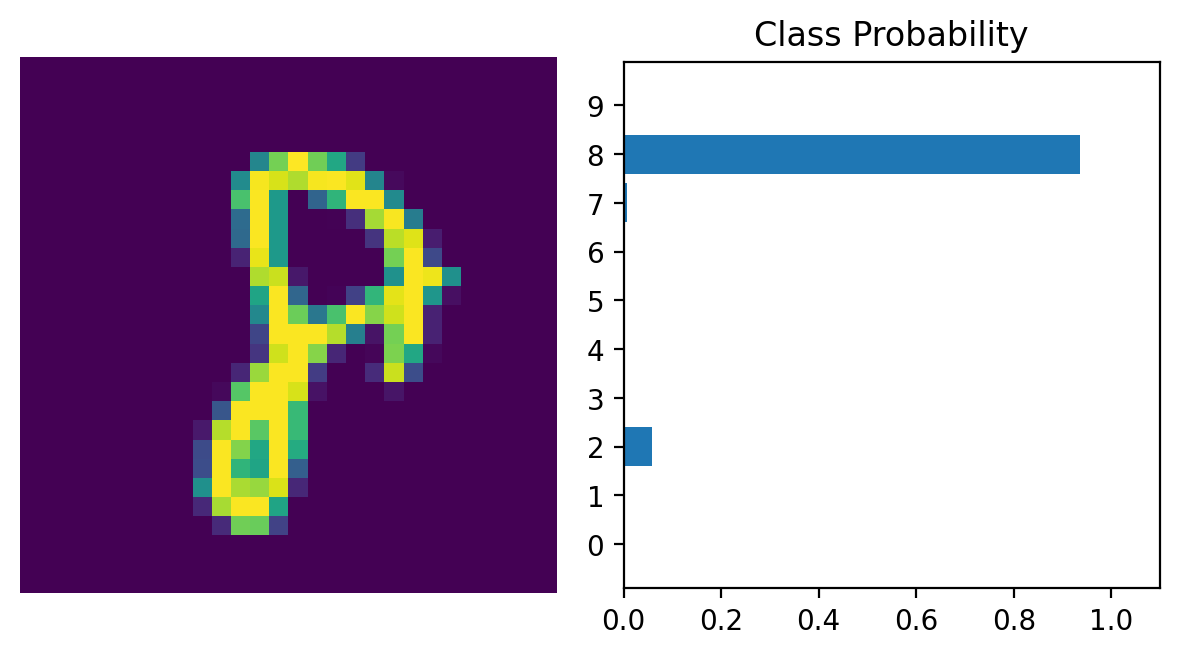

In [16]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img.to(device))

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

### Model Evaluation

In [17]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img.to(device))

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9758
